In [ ]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

     |████████████████████████████████| 1.9 MB 4.1 MB/s 
     |████████████████████████████████| 462 kB 79.4 MB/s 
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-83l6m85o/pafy_5848fc7abb644999bc7387d351c3f13f
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-install-83l6m85o/pafy_5848fc7abb644999bc7387d351c3f13f
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35706 sha256=f5abd252142fe8cb6081f9868eff3d2b6dbca9c4be88cef326ac30f98b42c505
  Stored in directory: /tmp/pip-ephem-wheel-cache-nnlnuzcb/wheels/64/82/dd/3d7823b3bbbe1aca9b30f8cf0d6bb6c1b72ccd95e3360f8190
Successfully built pafy


In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import glob

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2703360/45929032 bytes (5.9%)6963200/45929032 bytes (15.2%)11165696/45929032 bytes (24.3%)15376384/45929032 bytes (33.5%)19472384/45929032 bytes (42.4%)23683072/45929032 bytes (51.6%)27746304/45929032 bytes (60.4%)31866880/45929032 bytes (69.4%)36110336/45929032 bytes (78.6%)40353792/45929032 bytes (87.9%)44564480/45929032 bytes (97.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


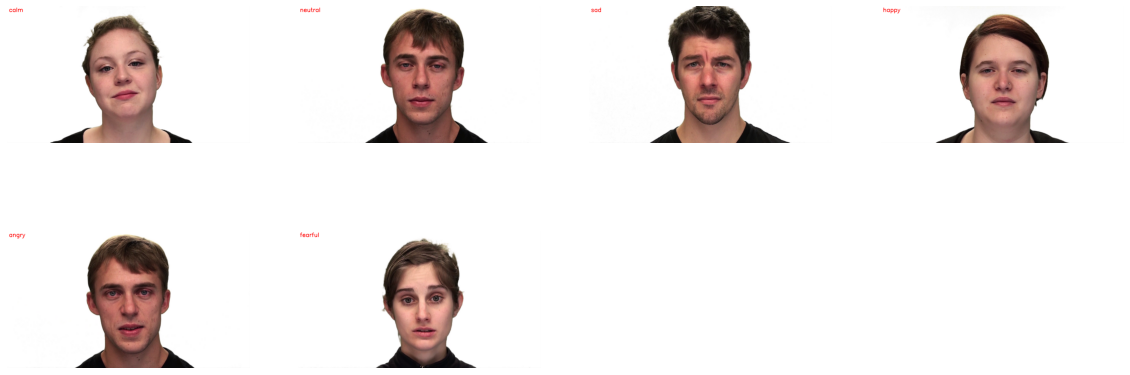

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('/content/drive/MyDrive/videospeechsong_label')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)),6)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/videospeechsong_label/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/videospeechsong_label/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
 # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/content/drive/MyDrive/frames_ravdess_label"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["neutral", "calm", "happy", "sad","angry","fearful"]

In [ ]:
def read_frames(frame_path):
  frames_list=[]
  empty_list=[]
  c1=0
  c2=0
  for filename in glob.glob(frame_path+'/*.jpg'):
    if filename is not None:
      #print(filename)
      
      img=cv2.imread(os.path.join(filename))
      if type(img) is np.ndarray:
            if img.size == 0:
                empty_list.append(filename)
                c1+=1
                continue
      if img is None:
            empty_list.append(filename)
            c2+=1
            continue
      resized_frame = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
      # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
      normalized_frame = resized_frame / 255
        
      # Append the normalized frame into the frames list
      frames_list.append(normalized_frame)
  return frames_list,empty_list,c1,c2
  

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    count1=0
    count2=0
    empty_path=[]
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        #print(files_list)
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            #print(video_file_path)
            frames,emp,co1,co2=read_frames(video_file_path)

            # Extract the frames of the video file.
            #frames = frames_extraction(file_name,class_name)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
            empty_path.append(emp)
            count1+=co1
            count2+=co2
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
   # Return the frames, class index, and video file path.
    return features, labels, video_files_paths,empty_path,count1,count2

In [ ]:
# Create the dataset.
features, labels, video_files_paths ,invalid_path,sum1,sum2= create_dataset()

Extracting Data of Class: neutral
Extracting Data of Class: calm
Extracting Data of Class: happy
Extracting Data of Class: sad
Extracting Data of Class: angry
Extracting Data of Class: fearful


In [ ]:
#invalid frame
#'/content/drive/MyDrive/frames_ravdess_label/sad/01-01-04-02-01-02-03.mp4/frame_1.94.jpg'
#01-01-04-02-01-02-03.mp4/frames/frame_1.94.jpg
#src=>/content/drive/MyDrive/graduation project/video/marwa/features/preprocessed_speech/Actor_03/01-01-04-02-01-02-03.mp4/frames/frame_1.94.jpg

In [ ]:
# Saving joblib files to not load them again with the loop above

import joblib

save_dir = '/content/drive/My Drive/features/'

savedvX = joblib.dump(features, os.path.join(save_dir, 'features_data'))
savedvy = joblib.dump(labels, os.path.join(save_dir, 'labels'))
savedstv = joblib.dump(video_files_paths, os.path.join(save_dir, 'video_path'))


In [ ]:
import joblib
features = joblib.load('/content/drive/My Drive/features/features_data')
labels = joblib.load('/content/drive/MyDrive/features/labels')
video_files_paths = joblib.load('/content/drive/My Drive/features/video_path')

In [ ]:
features = np.asarray(features)
labels = np.array(labels)  

In [ ]:
features.shape

(2067, 30, 64, 64, 3)

In [ ]:
labels.shape

(2067,)

In [ ]:
len(video_files_paths)

2067